In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mushroom/train.csv
/kaggle/input/mushroom/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef
import numpy as np
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the training and test datasets
train_df = pd.read_csv('/kaggle/input/mushroom/train.csv')
test_df = pd.read_csv('/kaggle/input/mushroom/test.csv')

# Display the first few rows of the train dataset
train_df.head(3)


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w


In [4]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64
id                            0
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing             839595
gill-color                 

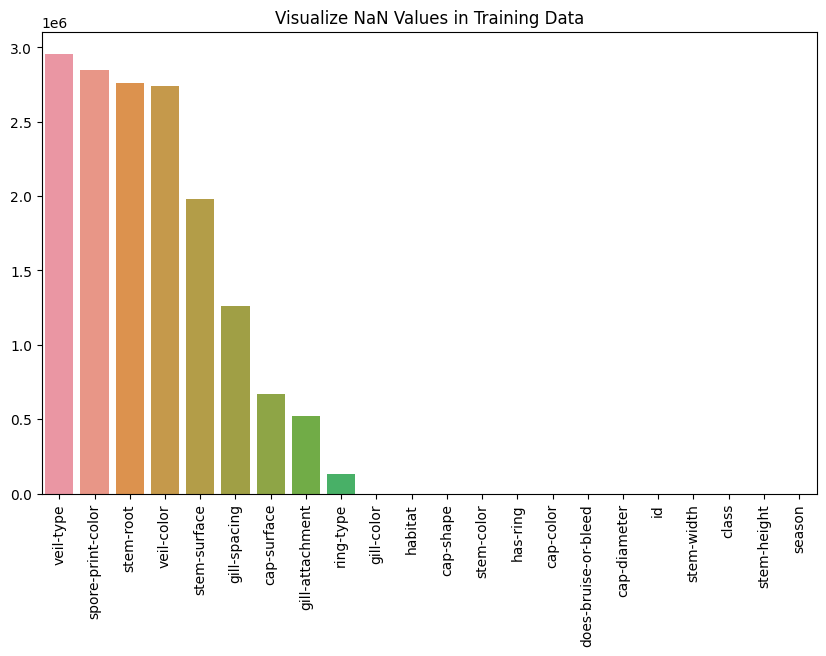

In [5]:
train_nan_sum = train_df.isnull().sum()
train_nan_sum = train_nan_sum.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=train_nan_sum.index, y=train_nan_sum.values)

plt.title('Visualize NaN Values in Training Data')
plt.xticks(rotation=90)

plt.show()

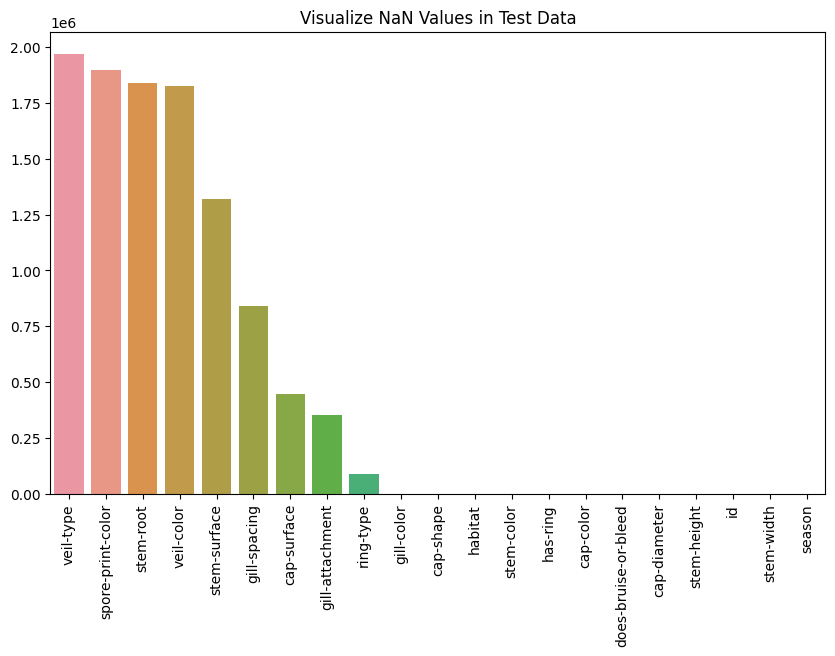

In [6]:
test_nan_sum = test_df.isnull().sum()
test_nan_sum = test_nan_sum.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=test_nan_sum.index, y=test_nan_sum.values)

plt.title('Visualize NaN Values in Test Data')
plt.xticks(rotation=90)

plt.show()

High similarity in the NaN values, so instead of dropping column or replacing, we can keep the NaN values and train are model with them

### Encode categorical column

In [7]:
train_df['class'] = train_df['class'] =='p'

encoder  = TargetEncoder()
cat_features = [val for val in train_df.drop(columns = 'class').select_dtypes(exclude ='number').columns]
for feature in cat_features:
    train_df[feature] = encoder.fit_transform(train_df[feature], train_df['class'])
    test_df[feature] = encoder.transform(test_df[feature])

### Split

In [8]:
X = train_df.drop(['class'], axis=1)
y = train_df['class']

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=5)

clf = xgb.XGBClassifier(
    max_depth=8,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    learning_rate=0.1,    
    n_estimators=2000,
    random_state=5,
    device="cuda", 
    tree_method = "hist",
    eval_metric="logloss",     
    early_stopping_rounds=8,
)

preds = clf.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],
    verbose=True               
)

preds = clf.predict(test_df)
output = pd.DataFrame({'id': test_df.id, 'class': preds})
output['class'] = output['class'].replace({1: 'p', 0: 'e'})
output.to_csv('my_submission.csv', index=False)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:08:45] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.62325
[1]	validation_0-logloss:0.56728
[2]	validation_0-logloss:0.52031
[3]	validation_0-logloss:0.47825
[4]	validation_0-logloss:0.43958
[5]	validation_0-logloss:0.40722
[6]	validation_0-logloss:0.37811
[7]	validation_0-logloss:0.35271
[8]	validation_0-logloss:0.32791
[9]	validation_0-logloss:0.30975
[10]	validation_0-logloss:0.29141
[11]	validation_0-logloss:0.27396
[12]	validation_0-logloss:0.25917
[13]	validation_0-logloss:0.24427
[14]	validation_0-logloss:0.23487
[15]	validation_0-logloss:0.22505
[16]	validation_0-logloss:0.21492
[17]	validation_0-logloss:0.20497
[18]	validation_0-logloss:0.19816
[19]	validation_0-logloss:0.18679
[20]	validation_0-logloss:0.18065
[21]	validation_0-logloss:0.17610
[22]	validation_0-logloss:0.17053
[23]	validation_0-logloss:0.16261
[24]	validation_0-logloss:0.15422
[25]	validation_0-logloss:0.14780
[26]	validation_0-logloss:0.14120
[27]	validation_0-logloss:0.13859
[28]	validation_0-logloss:0.13556
[29]	validation_0-loglos